# Assignment 5: Neuroevolution

**Goal**: Implement an Evolutionary Algorithm to optimize an Artificial Neural Network (ANN) based controller for the CartPole task in OpenAI Gym environment.

CartPole evaluation environment functions are provided. Your goal is to implement your ANN to control the cartpole and use your Evolutionary Algorithm to optimize the ANN parameters (weights).

Please answer the `Questions` and implement coding `Tasks` by filling **PLEASE FILL IN** sections. *Documentation* of your code is also important. You can find the grading scheme in implementation cells.

  * Plagiarism is automatically checked and set to **0 points**

  * It is allowed to learn from external resources but copying is not allowed. If you use any external resource, please cite them in the comments (e.g. `# source: https://...../` (see `fitness_function`))

**Install Prerequisites**

In [ ]:
# Run this cell to install the required libraries
%pip install numpy matplotlib scipy

**Imports**

In [ ]:
# Necessary libraries
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
# Enables inline matplotib graphs
%matplotlib inline

# Comment the line above and uncomment the lines below to have interactive plots
# WARN: may cause dependency issues
# %matplotlib qt5
# %pip install PyQt5
# plt.ion()

In [ ]:
%pip install gymnasium
import gymnasium as gym

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 16.9 MB/s eta 0:00:00


---
**Question 1 (0-0.25-0.5 pt):** Following link provides more information about the CartPole environemnt we would like to find an ANN to control: https://www.gymlibrary.dev/environments/classic_control/cart_pole/

Please have a look at the link and note the observation and action spaces, how many dimensions they have? Are they continous or discrete, and what kinds of value they can get?

**Answer:** The observation space has 4 dimensions, the cart position, velocity, pole angle and pole angular velocity. The action space is discrete can be either 0 (moving to the left) or 1 (moving to the right). The observation space is continouous and the cart position takes values between -4.8 and 4.8 (episode terminates if cart leaves -2.4 and 2.4 range), velocity is between -inf and inf, pole angle between -.418 and .418 radians (episode terminates if pole angle exits -.2095 and .2095 range), and finally the pole angular velocity between -inf and inf.

---
**Question 2 (0-0.25-0.5 pt):** What is your proposed ANN architecture and why? Please also discuss the activation functions you choose.

**Answer:** My proposed ANN architecture has 4 input neurons for the four observation space variables i.e. the cart position, velocity, pole angle and pole angular velocity.
It then has a hidden layer with 16 neurons with a ReLU activation function. I chose the ReLU as it is computationally efficient, simple and has the capacity to introduce necessary non-linearity.
FInally the output layer consists of 2 neurons which represent= the two variables in the action state: move left or move right. The activation fucntion will be a linear activation as it will allow for Q-learning

---
**Task 1: Implementation of Evolutionary Algrotihm (0-1.6-3.8-4.2-5 pt):** Implement your evolutionary algorithm to find an ANN controller for the CartPole task.

#### Check Your Implementation: Running The Evolutionary Algorithm

Run the cell below, if you implemented everything correctly, you should see the algorithm running. Furthermore,

In [ ]:
#################################
# Grading
# 0 pts if the code does not work, code works but it is fundamentally incorrect
# 1.6 pts if the code works but some functions are incorrect and it is badly explained
# 3.8 pts if the code works but some functions are incorrect but it is explained well
# 4.2 pts if the code works very well aligned with the task without any mistakes, but it is badly explained
# 5 pts if the code works very well aligned with the task without any mistakes, and it is well explained
################################################################

# Artificial Neural Network parameters (weights)
# See here: https://www.gymlibrary.dev/environments/classic_control/cart_pole/ for input and output space
inp = 4  # Number of input neurons
hid = 16  # Number of hidden neurons
out = 2  # Number of output neurons

# Initialize the environment
env = gym.make("CartPole-v1")

# Activation function for the ANN.
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Cartpole Evaluation Function
def cartpole(params):
  #changed the x to params so that the variable for sigmoid wouldn't be confusing for me :)
    w1 = np.array(params[:inp * hid]).reshape((inp, hid))
    b1 = np.array(params[inp * hid:inp * hid + hid]).reshape((1, hid))
    w2 = np.array(params[inp * hid + hid:inp * hid + hid + hid * out]).reshape((hid, out))
    b2 = np.array(params[inp * hid + hid + hid * out:]).reshape((1, out))

    #This is the ANN funtion, which defines a basic feedforward neural network
    #which takes as input an observation and returns a possible action as its output
    def nn(obs):
        obs = np.array(obs).reshape((1, inp))
        h = sigmoid(np.dot(obs, w1) + b1)
        out = np.dot(h, w2) + b2
        return out

    obs = env.reset()
    total_reward = 0
    done = False
    max_steps = 1000

    while not done:
        action_vals = nn(obs)
        action = np.argmax(action_vals)
        obs, reward, done, _ = env.step(action)
        total_reward += reward

    env.close()
    return min(max_steps, total_reward)

# Cartpole evaluation with visualization
def cartpole_visualize(params):
    env_vis = gym.make("CartPole-v1", render_mode="human")

    w1 = np.array(params[:inp * hid]).reshape((inp, hid))
    b1 = np.array(params[inp * hid:inp * hid + hid]).reshape((1, hid))
    w2 = np.array(params[inp * hid + hid:inp * hid + hid + hid * out]).reshape((hid, out))
    b2 = np.array(params[inp * hid + hid + hid * out:]).reshape((1, out))

    def nn(obs):
        obs = np.array(obs).reshape((1, inp))
        h = sigmoid(np.dot(obs, w1) + b1)
        out = np.dot(h, w2) + b2
        return out

    obs = env_vis.reset()
    total_reward = 0
    done = False
    max_steps = 1000

    while not done:
        action_vals = nn(obs)
        action = np.argmax(action_vals)
        obs, reward, done, _ = env_vis.step(action)
        total_reward += reward
        env_vis.render()

    env_vis.close()
    return min(max_steps, total_reward)

# Evolutionary Algorithm to find the ANN weights
def ea(pop_size, max_evals, p_cross, m_rate, obj_func):
    #Initialization of Population and checking their fitness scores
    ind_len = inp * hid + hid + hid * out + out
    population = [np.random.uniform(-1, 1, ind_len) for _ in range(pop_size)]
    fitness = [obj_func(ind) for ind in population]
    evals = pop_size

    #This function checks the current best solution and its fitness (score)
    best_fit = max(fitness)
    best_sol = population[np.argmax(fitness)]

    while evals < max_evals:
        fit_sum = sum(fitness)
        sel_probs = [f / fit_sum for f in fitness]
        #Parent Selection
        parents = np.random.choice(len(population), size=(pop_size, 2), p=sel_probs)
        new_pop = []

        #Crossover and Mutation functions
        for i1, i2 in parents:
            if np.random.rand() < p_cross:
                cross_pt = np.random.randint(1, ind_len - 1)
                child = np.concatenate([population[i1][:cross_pt], population[i2][cross_pt:]])
            else:
                child = population[i1].copy()
            mutate = np.random.rand(ind_len) < m_rate
            child[mutate] += np.random.normal(0, 0.1, mutate.sum())
            new_pop.append(child)

        #Evaluate the fitness of the new population
        new_fit = [obj_func(ind) for ind in new_pop]
        evals += len(new_pop)

        #Survivor Selection
        combined_pop = population + new_pop
        combined_fit = fitness + new_fit
        best_indices = np.argsort(combined_fit)[-pop_size:]
        population = [combined_pop[i] for i in best_indices]
        fitness = [combined_fit[i] for i in best_indices]

        #Update best solution/fitness
        if max(fitness) > best_fit:
            best_fit = max(fitness)
            best_sol = population[np.argmax(fitness)]

    return best_sol, best_fit


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
# Dummy parameters, please add or remove based on your implementation
kwargs = {
    "pop_size": 20,
    "max_evals": 5000,  # maximum number of fitness evaluations
    "p_cross": 0.8,  # crossover probability
    "m_rate": 0.2,  # mutation rate
    "obj_func": cartpole,
}
# Run your algorithm once and find the best ANN weigths found
env = gym.make("CartPole-v1")
x_best, f_best = ea(**kwargs)


# Print the best ANN weigths found and best fitness
print("Best ANN parameters found:",x_best)
print("Best fitness found:",f_best)


# Evaluate your ANN weights again and record the video
if f_best >= 1000:
  cartpole_visualize(x_best)
else:
  print("The best fitness 1000 was not found, try again!!")


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Best ANN parameters found: [ 0.03640475  0.06621107  0.06526443 -0.86522216  0.7551275   0.40423188
 -0.06509645  0.91317459  0.66365472 -0.41518317  0.06345023 -0.23034974
 -0.39198584 -0.69602848  0.68436993 -0.54505106 -0.7672023  -0.92051269
  0.11678972 -0.59408608  0.67874307 -0.56117832 -0.97087112  0.13882903
 -0.61319538  0.87437822 -0.19970782 -0.02936537  0.04851706 -0.66824612
 -0.76726976  0.1356096   0.25553613  0.50928921  0.12798238  0.89531106
 -0.86626873  0.46236967 -0.066988    0.13354225  0.86772604 -1.08085081
  0.8111646   0.00643481  0.54506661 -0.19972799  1.156352   -0.23377901
 -0.32678123  0.81849989  0.74655845  0.72370674  1.03841003  0.08644208
  0.8498846   0.40228417  0.64739856  0.87876189 -0.76757277  0.98259103
 -0.95107453 -0.71120198 -1.06008985 -0.26137261  1.2047841  -0.29216442
  0.42721873 -0.45112991  0.21749553  0.0299465   0.4485139  -0.01949465
  0.3590702   0.80552087 -0.48079579  0.8668775   0.4149735  -0.35636232
  0.69210979  0.82809469

---
**Question 3 (0-0.25-0.5 pt):** Please comment on the behavior of the final solution. Were you able to find the best solution (i.e. ANN weights which achieves best fitness: 1000) and was it possible to controll the CartPole task without letting the the pole fall?

**Answer:** I was unable to find thes best solution i.e. 1000 but I was able to reach the threshold of 500. I am still unsure as to why that was the case. I made multiple changes to a variety of parameters from increasing the max evaluations, to the number of hidden neurons but whatever I did seemed to make no difference. I also tried to include a clause in the evolutionary algorithm after the 'while fit_evals < max_fit_evals' to add a best_fitness < 1000 in order to try and force the evolutionary algorithm to keep going until a fitness of 1000 was reached but it seemed to have no effect

**Average results of your algorithm**

Remember that the EAs are sthocastic algorithms that can produce different results as a result of independent runs.

Therefore, we would like to see the average results and standard deviations.


---
**Task 2 (0-1.5-3 pt):** Please run your algorithm for at least 10 times and plot the average results and standard deviations. Below, you may add as many cells as you need for this implementation and plot functions. You may use previous code you have developed/used during the course.

Average Fitness: 500.0
Standard Deviation of Fitness: 0.0


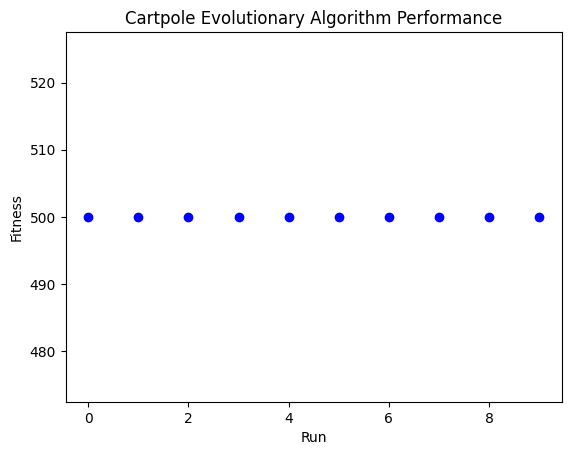

In [ ]:
import matplotlib.pyplot as plt

#function to run the above code 'num_runs' number of times. It records the best fitnesses and solutions for each run
def run_multiple_runs(num_runs, pop_size, max_evals, p_cross, m_rate, obj_func):
    best_fitnesses = []
    best_solutions = []

    for _ in range(num_runs):
        x_best, f_best = ea(pop_size, max_evals, p_cross, m_rate, obj_func)
        best_fitnesses.append(f_best)
        best_solutions.append(x_best)

    return best_fitnesses, best_solutions

#Calculate average of all the runs
def average_fit(best_fitnesses):
    return sum(best_fitnesses) / len(best_fitnesses)

#Calculate standard deviation of all the runs
def std_dev(best_fitnesses):
    return np.std(best_fitnesses)

#Code Execution, prints the average fitness and the standard deviation of fitness
#reduced number of max_evals as it made the runs too long when it is 5000
num_runs = 10
pop_size = 20
max_evals = 1000
p_cross = 0.8
m_rate = 0.2

best_fitnesses, _ = run_multiple_runs(num_runs, pop_size, max_evals, p_cross, m_rate, cartpole)
average_fitness = average_fit(best_fitnesses)
std_dev_fitness = std_dev(best_fitnesses)

print("Average Fitness:", average_fitness)
print("Standard Deviation of Fitness:", std_dev_fitness)

# Plot results of average and has standard deviation as error bars, but since it is zero you can't see them :(
plt.errorbar(range(num_runs), best_fitnesses, yerr=std_dev_fitness, fmt='o', color='blue', ecolor='lightgray', elinewidth=3, capsize=0)
plt.xlabel('Run')
plt.ylabel('Fitness')
plt.title('Cartpole Evolutionary Algorithm Performance')
plt.show()


---
**Question 4 (0-0.25-0.5 pt):** Please comment on the average behavior of your algorithm. How did the average results and standard deviations look? Did your algorithm converge all the time to the best fitness?

**Answer:** The performance of the algorithm remained static as shown by the standard deviation being 0.0 and the average being 500, which is good in the sense that it is the minimum threshold for the cartpole function, but it shows that the evolutionary aglortihm doesn't allow for enough exploration in terms of parent/survivor selection, which could possibly lead to solutions that may have given the best fitness of 1000